In [2]:
import torch
import torch.backends.cudnn as cudnn
import torch.nn.parallel
import torchvision
import torchvision.transforms as transforms

from models import *
from utils import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Data
print('==> Preparing data..')

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)


# Model
print('==> Building model..')
net_test = VGG('VGG16')

net_test = net_test.to(device)
if device == 'cuda':
    net_test = torch.nn.DataParallel(net_test)
    cudnn.benchmark = True

dir_name='./checkpoint/vgg16_92.24.pth'
dict = torch.load(dir_name)

==> Preparing data..
Files already downloaded and verified
==> Building model..


In [3]:
nlist_set=[[32,32], [8, 1, 16, 1, 2, 1, 32, 2, 1], [4, 32, 1, 4, 1, 2, 4, 2, 1, 2, 1, 2, 1, 1, 4, 1, 1], [16, 16, 1, 4, 8, 1, 4, 32, 16, 8, 1, 2, 4, 8, 4, 2, 1], [16, 16, 64, 32], [16, 128, 1, 4, 32, 16, 1, 4, 16, 2, 1, 8, 8, 2, 16, 1], [128, 2, 2, 16, 8, 8, 1, 32, 1, 1, 1, 32, 2, 16, 1, 2, 1, 2], [4, 16, 2, 128, 16, 1, 4, 16, 16, 8, 32, 2, 2, 2, 1, 2, 1, 2, 1], [2, 128, 32, 4, 128, 1, 2, 8, 4, 32, 8, 32, 4, 16, 16, 32, 2, 32, 16, 8, 2, 1, 1, 1], [1, 64, 32, 256, 2, 32, 64, 4, 16, 4, 32, 4, 1], [8, 2, 64, 4, 256, 4, 64, 16, 4, 32, 32, 16, 4, 1, 1, 1, 2, 1], [4, 4, 128, 256, 16, 8, 64, 4, 2, 8, 8, 1, 8, 1], [8, 256, 1, 128, 4, 64, 8, 8, 32, 1, 2]]

In [4]:
# Test the encryption performance layer by layer
import time
weight_name = prepare.search_conv(net_test)

acm_time_common = []
acm_acc_common = []
backer_time_common = []
backer_acc_common = []
common_layer=[]

acm_time_special = []
acm_acc_special = []
backer_time_special = []
backer_acc_special = []
special_layer=[]

i=0
temp_acm_acc=0
temp_backer_acc=0

for name in weight_name:
    i=i+1
    dict = torch.load(dir_name)
    print(name)
    a = dict[name].clone()
    print(a.shape)

    if a.shape[0]==a.shape[1]:
        common_layer.append(i)

        start_time = time.time()
        new = baker_encryption(a,nlist_set[i-1])
        end_time = time.time()
        t1 = end_time - start_time
        print("Backer time: %.3f s" % t1)
        backer_time_common.append(t1)
        dict[name] = new
        net_test.load_state_dict(dict)
        temp = easy_test(testloader, net_test)
        print("Backer accuracy: %.3f " % temp + '%')
        backer_acc_common.append(temp)
        print('')

        start_time = time.time()
        new = ACM(a,5)
        end_time = time.time()
        t2 = end_time - start_time
        print("ACM: time: %.3f s" % t2)
        acm_time_common.append(t2)
        dict[name] = new
        net_test.load_state_dict(dict)
        temp = easy_test(testloader, net_test)
        acm_acc_common.append(temp)
        print("ACM accuracy: %.3f " % temp + '%')
        print(round((t2-t1)/t2*100,2),'%')
        print('='*40)

    else:
        
        special_layer.append(i)
        start_time = time.time()
        new = baker_encryption(a,nlist_set[i-1])
        end_time = time.time()
        t1 = end_time - start_time
        print("Backer time: %.3f s" % t1)
        backer_time_special.append(t1)
        dict[name] = new
        net_test.load_state_dict(dict)
        temp = easy_test(testloader, net_test)
        print("Backer accuracy: %.3f " % temp + '%')
        backer_acc_special.append(temp)
        print('')

        start_time = time.time()
        new = ACM(a,5)
        end_time = time.time()
        t2 = end_time - start_time
        print("ACM: time: %.3f s" % t2)
        acm_time_special.append(t2)
        dict[name] = new
        net_test.load_state_dict(dict)
        temp = easy_test(testloader, net_test)
        acm_acc_special.append(temp)
        print("ACM accuracy: %.3f " % temp + '%')
        print(round((t2-t1)/t2*100,2),'%')
        print('='*40)


module.features.0.weight
torch.Size([64, 3, 3, 3])
Backer time: 0.005 s
Backer accuracy: 26.790 %

ACM: time: 0.007 s
ACM accuracy: 91.230 %
17.8 %
module.features.3.weight
torch.Size([64, 64, 3, 3])
Backer time: 0.030 s
Backer accuracy: 9.750 %

ACM: time: 0.086 s
ACM accuracy: 10.610 %
65.34 %
module.features.7.weight
torch.Size([128, 64, 3, 3])
Backer time: 0.048 s
Backer accuracy: 7.180 %

ACM: time: 0.095 s
ACM accuracy: 45.320 %
49.69 %
module.features.10.weight
torch.Size([128, 128, 3, 3])
Backer time: 0.052 s
Backer accuracy: 7.080 %

ACM: time: 0.291 s
ACM accuracy: 12.720 %
82.24 %
module.features.14.weight
torch.Size([256, 128, 3, 3])
Backer time: 0.193 s
Backer accuracy: 7.560 %

ACM: time: 0.270 s
ACM accuracy: 66.610 %
28.75 %
module.features.17.weight
torch.Size([256, 256, 3, 3])
Backer time: 0.426 s
Backer accuracy: 7.370 %

ACM: time: 1.074 s
ACM accuracy: 8.950 %
60.32 %
module.features.20.weight
torch.Size([256, 256, 3, 3])
Backer time: 0.326 s
Backer accuracy: 6.700

In [5]:
import matplotlib.pyplot as plt
import numpy as np

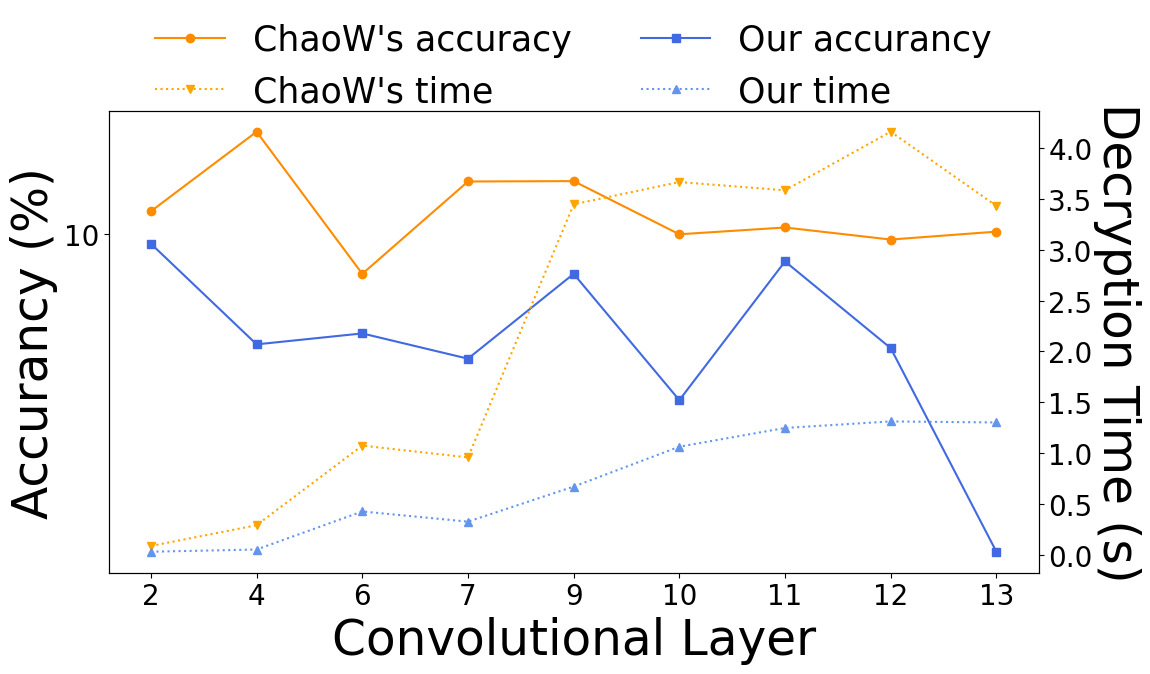

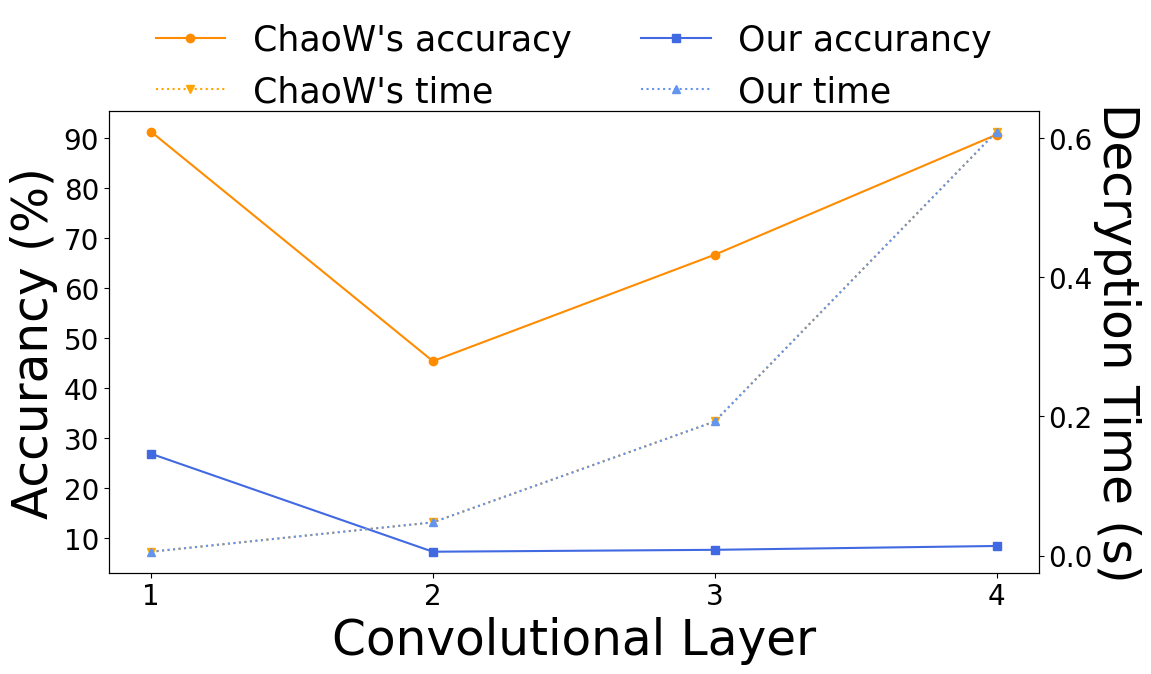

In [6]:
fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
ax1.set_xlabel('Convolutional Layer',fontsize=35)
ax1.set_ylabel('Accurancy (%)',fontsize=35)
x=list(range(1,len(acm_acc_common)+1))
ax1.set_xticks(x)
ax1.set_yticks(range(0,100,10))
t=round(max(max(acm_time_common),max(backer_time_common))+0.5,1)
ax2.set_yticks(np.arange(0, t, 0.5))

ax2.set_ylabel('Decryption Time (s)',rotation=-90,x=2,fontsize=35)
ax2.yaxis.set_label_coords(1.11,0.5)
ax1.set_xticklabels(common_layer)

l11,=ax1.plot(x,acm_acc_common,color='darkorange', marker='o' )
l12,=ax1.plot(x,backer_acc_common,color='royalblue', marker='s' )

# l11=ax1.bar(x, acm_acc_common, fc='lightgrey')
# l12=ax1.bar(x, backer_acc_common, fc='lightskyblue')

l21,=ax2.plot(x,acm_time_common,linestyle='dotted',color='orange', marker='v' )
l22,=ax2.plot(x,backer_time_common,linestyle='dotted', color='cornflowerblue',marker='^' )
ax1.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
ax1.legend(handles=[l11,l21,l12,l22], labels=['ChaoW\'s accuracy','ChaoW\'s time','Our accurancy','Our time'],borderaxespad = 0.,loc=9,bbox_to_anchor=(0.5,1.22),ncol=2,frameon=False,fontsize=25)
#ax1.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.) ##设置ax4中legend的位置，将其放在图外

plt.savefig('./output/vgg16_cmp.pdf', dpi=300,bbox_inches = 'tight')
####################################################

fig, ax1 = plt.subplots(figsize=(12, 6))
ax2 = ax1.twinx()
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
ax1.set_xlabel('Convolutional Layer',fontsize=35)
ax1.set_ylabel('Accurancy (%)',fontsize=35)
x=list(range(1,len(acm_acc_special)+1))
ax1.set_xticks(x)
ax1.set_yticks(range(0,100,10))
t=round(max(max(backer_time_special),max(backer_time_special))+0.5,1)
ax2.set_yticks(np.arange(0.0, t, 0.2))
ax2.set_ylabel('Decryption Time (s)',rotation=-90,x=2,fontsize=35)
ax2.yaxis.set_label_coords(1.11,0.5)


l11,=ax1.plot(x,acm_acc_special,color='darkorange', marker='o' )
l12,=ax1.plot(x,backer_acc_special,color='royalblue', marker='s' )

# l11=ax1.bar(x, acm_acc_special, fc='lightgrey')
# l12=ax1.bar(x, backer_acc_special, fc='lightskyblue')

l21,=ax2.plot(x,backer_time_special,linestyle='dotted',color='orange', marker='v' )
l22,=ax2.plot(x,backer_time_special,linestyle='dotted', color='cornflowerblue',marker='^' )
ax1.tick_params(labelsize=20)
ax2.tick_params(labelsize=20)
ax1.legend(handles=[l11,l21,l12,l22], labels=['ChaoW\'s accuracy','ChaoW\'s time','Our accurancy','Our time'],borderaxespad = 0.,loc=9,bbox_to_anchor=(0.5,1.22),ncol=2,frameon=False,fontsize=25)
#ax1.legend(loc=2, bbox_to_anchor=(1.05,1.0),borderaxespad = 0.) ##设置ax4中legend的位置，将其放在图外
#ax1.set_xticklabels(special_layer,fontsize=8)

plt.savefig('./output/vgg16_cmp2.pdf', dpi=300,bbox_inches = 'tight')

In [11]:
f = open('./output/result_vgg16.txt' , 'w', encoding='gbk')

time_pro=[]
acc_pro=[]
time_pro_2=[]
acc_pro_2=[]
time_pro_avg=[]
acc_pro_avg=[]
for a in range(len(acm_time_common)):
    time_pro.append((acm_time_common[a]-backer_time_common[a])/acm_time_common[a])
    acc_pro.append((acm_acc_common[a]-backer_acc_common[a])/acm_acc_common[a])
time_pro_avg.append(round(sum(time_pro)/len(time_pro)*100,2))
acc_pro_avg.append(round(sum(acc_pro)/len(acc_pro)*100,2))


for a in range(len(backer_time_special)):
    time_pro_2.append((backer_time_special[a]-backer_time_special[a])/backer_time_special[a])
    acc_pro_2.append((acm_acc_special[a]-backer_acc_special[a])/acm_acc_special[a])
time_pro_avg.append(round(sum(time_pro_2)/len(time_pro_2)*100,2))
acc_pro_avg.append(round(sum(acc_pro_2)/len(acc_pro_2)*100,2))

print("Percentage of improvement:")
print("time%",time_pro_avg)
print("acc%",acc_pro_avg)

f.write("Percentage of improvement:\n")
f.write("time%:"+str(time_pro_avg)+"\n")
f.write("acc%:"+str(acc_pro_avg)+"\n")
f.flush()

time_pro=[]
acc_pro=[]
time_pro_2=[]
acc_pro_2=[]
time_pro_avg=[]
acc_pro_avg=[]
for a in range(len(acm_time_common)):
    time_pro.append((acm_time_common[a]-backer_time_common[a]))
    acc_pro.append((acm_acc_common[a]-backer_acc_common[a]))
time_pro_avg.append(round(sum(time_pro)/len(time_pro),2))
acc_pro_avg.append(round(sum(acc_pro)/len(acc_pro),2))


for a in range(len(backer_time_special)):
    time_pro_2.append((backer_time_special[a]-backer_time_special[a]))
    acc_pro_2.append((acm_acc_special[a]-backer_acc_special[a]))
time_pro_avg.append(round(sum(time_pro_2)/len(time_pro_2),2))
acc_pro_avg.append(round(sum(acc_pro_2)/len(acc_pro_2),2))

print("\nDifference value:")
print("time",time_pro_avg)
print("acc",acc_pro_avg)

f.write("\nDifference value:\n")
f.write("time:"+str(time_pro_avg)+"\n")
f.write("acc:"+str(acc_pro_avg)+"\n")
f.flush()



Percentage of improvement:
time% [69.02, 0.0]
acc% [33.25, 83.56]

Difference value:
time [1.59, 0.0]
acc [3.55, 60.98]
